In [18]:
import numpy as np
import tensorflow as tf
import time
from tensorflow.keras import layers
import sklearn.metrics as skm
import os
import matplotlib.pyplot as plt
import itertools

2023-06-14 13:49:30.789941: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
#Generate configurations

hidden_layers = [2, 3, 4]
hidden_nodes = [26, 5, 11, 20, 30, 33, 40]
activation = ['sigmoid', 'relu']

configurations = []

for index, combination in enumerate(itertools.product(hidden_layers, hidden_nodes, activation), 1):
    config = {
        'config_name': f'config{index}',
        'hidden_layers' : combination[0],
        'hidden_nodes': combination[1],
        'activation': combination[2]
    }
    configurations.append(config)

for dictionary in configurations:
    print(dictionary)



{'config_name': 'config1', 'hidden_layers': 2, 'hidden_nodes': 26, 'activation': 'sigmoid'}
{'config_name': 'config2', 'hidden_layers': 2, 'hidden_nodes': 26, 'activation': 'relu'}
{'config_name': 'config3', 'hidden_layers': 2, 'hidden_nodes': 5, 'activation': 'sigmoid'}
{'config_name': 'config4', 'hidden_layers': 2, 'hidden_nodes': 5, 'activation': 'relu'}
{'config_name': 'config5', 'hidden_layers': 2, 'hidden_nodes': 11, 'activation': 'sigmoid'}
{'config_name': 'config6', 'hidden_layers': 2, 'hidden_nodes': 11, 'activation': 'relu'}
{'config_name': 'config7', 'hidden_layers': 2, 'hidden_nodes': 20, 'activation': 'sigmoid'}
{'config_name': 'config8', 'hidden_layers': 2, 'hidden_nodes': 20, 'activation': 'relu'}
{'config_name': 'config9', 'hidden_layers': 2, 'hidden_nodes': 30, 'activation': 'sigmoid'}
{'config_name': 'config10', 'hidden_layers': 2, 'hidden_nodes': 30, 'activation': 'relu'}
{'config_name': 'config11', 'hidden_layers': 2, 'hidden_nodes': 33, 'activation': 'sigmoid'}
{'c

In [20]:
# Load the dataset
data_path = '/Users/as274094/Documents/psf_dataset2/'
# data_path = '/gpfswork/rech/prk/uzk69cg/psf_dataset2/'

In [21]:
def SEDlisttoC(SED_list):
    sed_array = np.array(SED_list)
    return sed_array*0.5 + 1.5

def CtoSEDarray(c_values, variance):
    sed_classes = ((c_values - 1.25) // 0.5).astype(int)
    sed_classes = np.where((c_values < 1.25) | (c_values > 7.75), 20, sed_classes)
    sed_classes = np.where((variance > 1.00), 20, sed_classes)
    return sed_classes

def calculate_success_rate(confusion_matrix):
    diagonal = np.trace(confusion_matrix)
    diagonal_neighbors = np.sum(np.diagonal(confusion_matrix, offset=1)) + np.sum(np.diagonal(confusion_matrix, offset=-1))
    total_classified = np.sum(confusion_matrix)
    
    success_rate = (diagonal + diagonal_neighbors) / total_classified
    return success_rate

In [22]:
class TrainingCompletionCallback(tf.keras.callbacks.Callback):
    def on_train_end(self, logs=None):
        epochs = len(self.model.history.history['loss'])
        final_loss = self.model.history.history['loss'][-1]
        final_val_loss = self.model.history.history['val_loss'][-1]

        print("Training completed. Number of epochs:", epochs, ", Final training loss:", final_loss, ", Final validation loss:", final_val_loss)

completion_callback = TrainingCompletionCallback()

initializer = tf.keras.initializers.GlorotNormal(seed = 25)

In [52]:
class full_model:
    def __init__(self, dataset_name, configuration):
        self.dataset_name = dataset_name
        dataset = np.load(data_path + dataset_name + ".npy", allow_pickle=True)[()]
        self.PCA_components = dataset['N_components']
        self.x_train = dataset['train_stars_pca']
        self.x_val = dataset['validation_stars_pca']
        self.x_test = dataset['test_stars_pca']
        self.y_train = dataset['train_C']
        self.y_val = dataset['validation_C']
        self.y_test = dataset['test_C']
        self.SED_val = dataset['validation_SEDs']
        self.SED_test = dataset['test_SEDs']
        self.learning = []
        self.configuration = configuration

    def create_model(self):
        
        self.model = tf.keras.Sequential()
        self.model.add(layers.Input(shape=[self.PCA_components]))
        for n_layers in range(self.configuration['hidden_layers']):
            self.model.add(layers.Dense(self.configuration['hidden_nodes'], activation= self.configuration['activation'], kernel_initializer= initializer))
        self.model.add(layers.Dense(1, activation = 'linear', kernel_initializer= initializer))
        
    
    def train_model(self, learning_rate, training_epochs, patience_epochs):

        self.model.compile(
            loss = tf.keras.losses.MeanSquaredError(),
            optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
        )
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = patience_epochs, restore_best_weights=True)

        learn = self.model.fit(self.x_train, self.y_train, epochs= training_epochs, verbose = 0,
                                        callbacks = [completion_callback,early_stopping], validation_data=(self.x_val,self.y_val), shuffle=True) 

        self.learning.append(learn)

    def predict_test(self, verbose = True):
        C_pred = self.model.predict(self.x_test, verbose = 0).reshape(-1)
        SED_pred_test = CtoSEDarray(C_pred,np.zeros_like(C_pred))

        self.mse_test = np.mean((self.y_test - C_pred)**2)
        self.f1_test = skm.f1_score(self.SED_test, SED_pred_test, average = None)
        self.f1_mean_test = np.mean(self.f1_test[:13])
        self.confusion_matrix_test = skm.confusion_matrix(self.SED_test, SED_pred_test)
        self.success_rate_test = calculate_success_rate(self.confusion_matrix_test)

        if(verbose):
            print("Prediction results for the test set")
            print('MSE:', self.mse_test)
            print('\nF1 score for each class:', self.f1_test)
            print('Average F1 score:', self.f1_mean_test)
            print("\nConfusion matrix:")
            print(self.confusion_matrix_test)
            print('\nSuccess rate:', self.success_rate_test)


    def predict_val(self, verbose = True):
        C_pred = self.model.predict(self.x_val, verbose = 0).reshape(-1)
        SED_pred_val = CtoSEDarray(C_pred,np.zeros_like(C_pred))

        self.mse_val = np.mean((self.y_val - C_pred)**2) 
        self.f1_val = skm.f1_score(self.SED_val, SED_pred_val, average = None)
        self.f1_mean_val = np.mean(self.f1_val[:13])
        self.confusion_matrix_val = skm.confusion_matrix(self.SED_val, SED_pred_val)
        self.success_rate_val = calculate_success_rate(self.confusion_matrix_val)

        if(verbose):
            print("Prediction results for the validation set")
            print('MSE:', self.mse_val)
            print('\nF1 score for each class:', self.f1_val)
            print('Average F1 score:', self.f1_mean_val)
            print("\nConfusion matrix:")
            print(self.confusion_matrix_val)
            print('\nSuccess rate:', self.success_rate_val)

    def save_model(self, N_model):

        self.model.save(f"saved_models/{self.configuration['config_name']}/{self.dataset_name}/my_model_{N_model}.h5")

    def load_model(self, N_model):
        self.model = tf.keras.models.load_model(f"saved_models/{self.configuration['config_name']}/{self.dataset_name}/my_model_{N_model}.h5")
        

    def plot_loss(self):
    # Plot the loss function evolution

        loss_evolution = self.learning[-1].history["loss"]
        val_loss_evolution = self.learning[-1].history["val_loss"]

        plt.figure(figsize = (9,5))
        plt.plot(loss_evolution,label = "Train set")
        plt.plot(val_loss_evolution,label = "Validation set")
        plt.xlabel("Epochs")
        plt.ylabel("Loss function value")
        plt.legend()
        plt.title("Loss function evolution")
        print("Training loss:", loss_evolution[-1], ", Validation loss:", val_loss_evolution[-1])

    def plot_cf_matrix(self):
        # Plot the confusion matrix

        star_class_labels = ['O5','B0','B5','A0','A5','F0','F5','G0','G5','K0','K5','M0','M5']

        plt.figure(figsize= (12,10))
        heatmap = plt.imshow(self.confusion_matrix_test[:13,:], cmap='Blues')
        plt.xticks(np.arange(14), star_class_labels + ['???'])
        plt.yticks(np.arange(13), star_class_labels)
        plt.colorbar(heatmap)
        plt.xlabel("Estimated spectral type")
        plt.ylabel("True spectral type")
        plt.show()

In [53]:
N_components = [24, 27]
model_array = np.empty((len(N_components),2), dtype=object)
k = 0

for i in range(model_array.shape[0]):
    for j in range(model_array.shape[1]):
        model = full_model('PCA_dataset2B' + str(N_components[i]), configuration= configurations[k])
        model.create_model()
        model.train_model(training_epochs= 10, learning_rate= 0.1, patience_epochs= 10)
        print(model.configuration, model.PCA_components)

        model_array[i][j]= model
        k += 1
    print('End of the training of PCA_dataset2B' + str(N_components[i]))

Training completed. Number of epochs: 10 , Final training loss: 0.18243852257728577 , Final validation loss: 0.1703483909368515
{'config_name': 'config1', 'hidden_layers': 2, 'hidden_nodes': 26, 'activation': 'sigmoid'} 24
Training completed. Number of epochs: 10 , Final training loss: 0.20327343046665192 , Final validation loss: 0.16509953141212463
{'config_name': 'config2', 'hidden_layers': 2, 'hidden_nodes': 26, 'activation': 'relu'} 24
End of the training of PCA_dataset2B24
Training completed. Number of epochs: 10 , Final training loss: 0.21886199712753296 , Final validation loss: 0.23780232667922974
{'config_name': 'config3', 'hidden_layers': 2, 'hidden_nodes': 5, 'activation': 'sigmoid'} 27
Training completed. Number of epochs: 10 , Final training loss: 0.24770399928092957 , Final validation loss: 0.21301104128360748
{'config_name': 'config4', 'hidden_layers': 2, 'hidden_nodes': 5, 'activation': 'relu'} 27
End of the training of PCA_dataset2B27


In [56]:
#Save the models
for i in range(model_array.shape[0]):
        for j in range(model_array.shape[1]):
            model = model_array[i][j]
            model.save_model(j)

In [57]:
# Load models
model_array2 = np.empty((len(N_components),2), dtype=object)

k = 0
for i in range(model_array2.shape[0]):
    for j in range(model_array2.shape[1]):
        model = full_model('PCA_dataset2B' + str(N_components[i]), configuration= configurations[k])
        model.load_model(j)
        model_array2[i][j] = model
        k +=1

In [103]:
def start_array(N_components, N_model_dataset, configuration):
    model_array = np.empty((len(N_components),N_model_dataset), dtype=object)

    total_start_time = time.time() # Measure training time
    for i in range(model_array.shape[0]):
        print('Start of the training of PCA_dataset2B' + str(N_components[i]))
        for j in range(model_array.shape[1]):
            model = full_model('PCA_dataset2B' + str(N_components[i]), configuration)
            model.create_model()

            single_start_time = time.time()
            model.train_model(training_epochs= 70, learning_rate= 0.1, patience_epochs= 10)
            model.train_model(training_epochs= 100, learning_rate= 0.01, patience_epochs= 12)
            single_end_time = time.time()
            single_training_time = single_end_time - single_start_time
            print("Model training time:", single_training_time, "seconds")

            model.predict_val(verbose=0)
            model.predict_test(verbose=0)
            model_array[i][j]= model
        print('End of the training of PCA_dataset2B' + str(N_components[i]))

    total_end_time = time.time()
    total_training_time = total_end_time - total_start_time
    print("Total training time:", total_training_time, "seconds")

    return model_array

def predict_array(model_array):
    for i in range(model_array.shape[0]):
        for j in range(model_array.shape[1]):
            model_array[i][j].predict_val(verbose=False)
            model_array[i][j].predict_test(verbose=False)

def save_model_array(model_array):
    for i in range(model_array.shape[0]):
        for j in range(model_array.shape[1]):
            model = model_array[i][j]
            model.save_model(j)

def load_model_array(N_components, N_model_dataset, configuration):
    model_array = np.empty((len(N_components), N_model_dataset), dtype=object)

    for i in range(model_array.shape[0]):
        for j in range(model_array.shape[1]):
            model = full_model('PCA_dataset2B' + str(N_components[i]), configuration)
            model.load_model(j)
            model_array[i][j] = model

    return model_array
    

In [ ]:
# Create model array

N_components = [12, 15, 18, 21, 24, 27, 30, 33]

model_array = start_array(N_components, 10, configurations[0])

In [101]:
predict_array(model_array)

In [50]:
def obtain_metric(model_array, metric):
    metric_array = np.zeros_like(model_array) 

    for i in range(model_array.shape[0]):
        for j in range(model_array.shape[1]):
            model = model_array[i][j]
            metric_array[i][j] = getattr(model, metric)
    return metric_array

def obtain_graph_values(model_array, metric):
    metric_array = obtain_metric(model_array, metric)

    mean_values = np.mean(metric_array, axis=1)
    min_values = np.min(metric_array, axis=1)
    max_values = np.max(metric_array, axis=1)  
    error_min = mean_values - min_values
    error_max = max_values - mean_values
    return mean_values, error_min, error_max

def obtain_best_models(model_array):
    best_models = np.empty((model_array.shape[0],1), dtype = object)

    F1_array = obtain_metric(model_array, 'f1_mean_test')
    indexes = np.argmax(F1_array, axis=1)
    print(indexes)
    for N in range(model_array.shape[0]):
        model = model_array[N][indexes[N]]
        best_models[N] = model

    return best_models

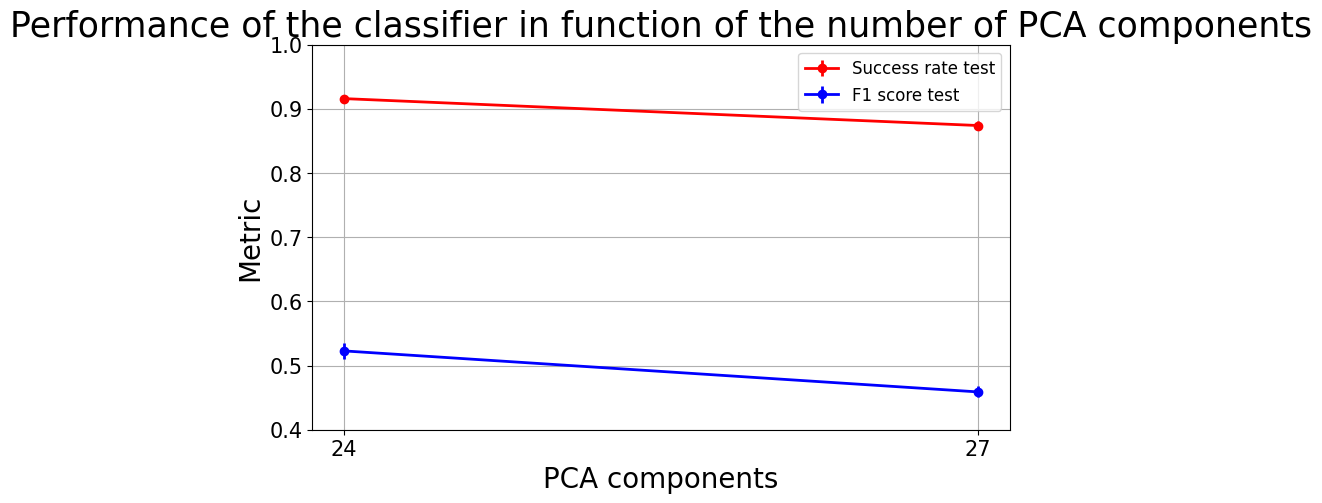

In [62]:
# Plot the metrics (with error bars) of the different datasets with multiple

mean_valuesSt, error_minSt, error_maxSt = obtain_graph_values(model_array2, 'success_rate_test')
mean_valuesF1t, error_minF1t, error_maxF1t = obtain_graph_values(model_array2, 'f1_mean_test')
mean_valuesSv, error_minSv, error_maxSv = obtain_graph_values(model_array2, 'success_rate_val')
mean_valuesF1v, error_minF1v, error_maxF1v = obtain_graph_values(model_array2, 'f1_mean_val')


# Generate x-axis values based on the first dimension of the arrays
x_values = N_components 

plt.subplots(figsize = (9,5))
# Plotting the graph
plt.errorbar(x_values, mean_valuesSt, yerr=[error_minSt, error_maxSt], fmt='o', label = "Success rate test", color = 'red', linestyle = '-', linewidth=2)
plt.errorbar(x_values, mean_valuesF1t, yerr=[error_minF1t, error_maxF1t], fmt='o', label = "F1 score test", color = 'blue',linestyle = '-', linewidth=2)
#plt.errorbar(x_values, mean_valuesSv, yerr=[error_minSv, error_maxSv], fmt='o', label = "Success rate validation", color = 'red', linestyle = '--', linewidth=2)
#plt.errorbar(x_values, mean_valuesF1v, yerr=[error_minF1v, error_maxF1v], fmt='o', label = "F1 score validation ", color = 'blue', linestyle = '--', linewidth=2)

plt.xlabel("PCA components", fontsize = 20)
plt.ylabel("Metric", fontsize = 20)
plt.xticks(N_components)
plt.yticks([0.4,0.5,0.6,0.7,0.8,0.9,1.0])
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.grid(True)
plt.legend(fontsize = 12)
plt.title('Performance of the classifier in function of the number of PCA components', fontsize = 25)
plt.show()

In [88]:
def obtain_graph_values2(model_array, metric):
    metric_array = obtain_metric(model_array, metric)

    mean_values = np.mean(metric_array, axis=1).astype(float)
    min_values = np.min(metric_array, axis=1).astype(float)
    max_values = np.max(metric_array, axis=1).astype(float)
    return mean_values, min_values, max_values

mean_valuesSt, minSt, maxSt = obtain_graph_values2(model_array, 'success_rate_test')
mean_valuesF1t, minF1t, maxF1t = obtain_graph_values2(model_array, 'f1_mean_test')

x_values = N_components 


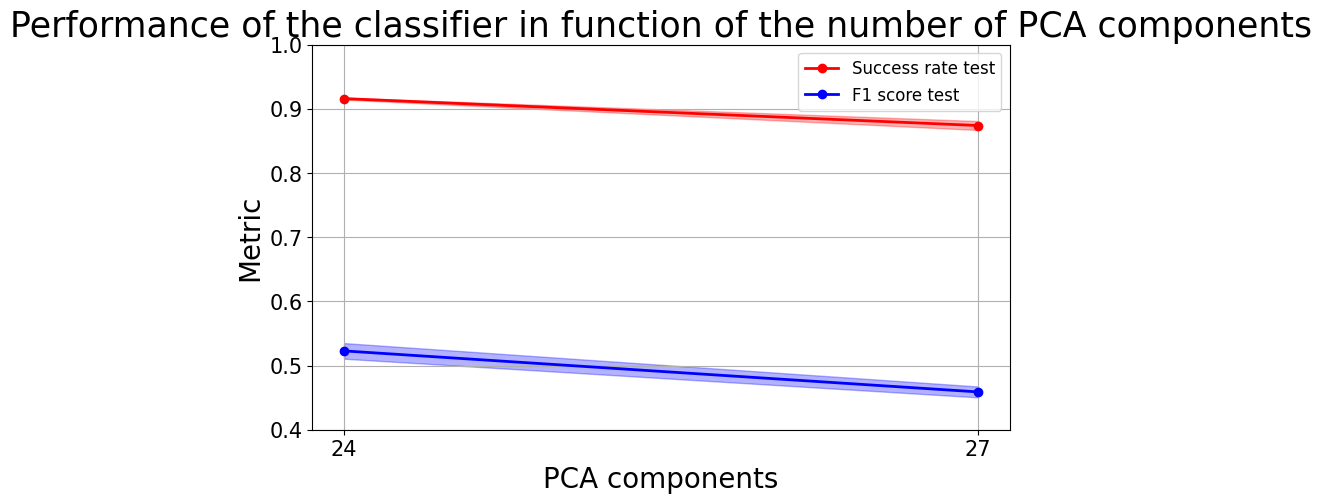

In [98]:

plt.subplots(figsize = (9,5))
# Plotting the graph

plt.plot(x_values, mean_valuesSt, '-o', label = "Success rate test", color = 'red', linewidth=2)
plt.fill_between(x_values, minSt, maxSt, alpha=0.3, color = 'red')

plt.plot(x_values, mean_valuesF1t, '-o', label = "F1 score test", color = 'blue', linewidth=2)
plt.fill_between(x_values, minF1t, maxF1t, alpha=0.3, color = 'blue')


plt.xlabel("PCA components", fontsize = 20)
plt.ylabel("Metric", fontsize = 20)
plt.xticks(N_components)
plt.yticks([0.4,0.5,0.6,0.7,0.8,0.9,1.0])
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.grid(True)
plt.legend(fontsize = 12)
plt.title('Performance of the classifier in function of the number of PCA components', fontsize = 25)
plt.show()